**Objectives**
- Determine which metrics affect clickthrough rate.
- Determine which actions would most likely increase clickthrough rate.
- Generate business insights relative with the clickthrough rate.

Block 1 is done, while Block 2 is halted.

# Dependencies

In [ ]:
%run /Repos/coltrane.torres@kumu.ph/kdp-data-science/scripts/ds-utils

In [ ]:
import numpy as np
import pandas as pd
import pyspark.pandas as ps
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when
import pyspark

#import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [ ]:
def findOutliers(df, numeric_columns):
    """
    source: https://deepnote.com/@rajshekar-2021/Outlier-Detection-Pyspark-069e69af-2c1d-4d4d-884a-92aad276d06f
    """
    # Identifying the numerical columns in a spark dataframe
#     numeric_columns = [column[0] for column in df.dtypes if column[1] in ['int', 'bigint', 'long']]

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)

        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]

        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        print(f'Thresholds for {column}: LB {less_Q1} UB {more_Q3}')
        
        isOutlierCol = 'is_outlier_{}'.format(column)
         
        df = df.withColumn(isOutlierCol,F.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))


    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

# Data Collection

**Viewer to Streamer (v2s)**

In [ ]:
# v2s = spark.sql('''

# WITH
# impressions AS
# (
#     SELECT
#         context_traits_userId AS user_id
#       , properties_channel_id
#       , properties_streamer_ids
#       , DATE_TRUNC('HOUR', originalTimestamp) as hr_trunc
#       , EXPLODE(SPLIT(TRIM('["]', properties_channel_id), ',')) AS for_you_streams
#     FROM kdp_segment_track.other_ios
#     WHERE event LIKE '%For You Livestream Seen%'
#         AND originalTimestamp >= DATE_SUB(CURRENT_DATE(), 14) --14

#     UNION ALL

#     SELECT
#         context_traits_userId AS user_id
#       , properties_channel_id
#       , properties_streamer_ids
#       , DATE_TRUNC('HOUR', originalTimestamp) as hr_trunc
#       , EXPLODE(SPLIT(TRIM('["]', properties_channel_id), ',')) AS for_you_streams
#     FROM kdp_segment_track.other_android
#     WHERE event LIKE '%For You Livestream Seen%'
#         AND originalTimestamp >= DATE_SUB(CURRENT_DATE(), 14) --14
# )
# ,

# impressions_cleaned AS
# (
#     SELECT
#        user_id
#       , hr_trunc
#       , TRIM('["]', for_you_streams) AS for_you_streams
#     FROM impressions
#     GROUP BY
#       user_id
#     , hr_trunc
#     , for_you_streams
    
# )
# ,

# clickthrough AS
# (
#     SELECT
#         context_traits_userId AS user_id
#       , DATE_TRUNC('HOUR', originalTimestamp) as hr_trunc
#       , TRIM('["]', properties_feed_id) AS for_you_streams
#     FROM kdp_segment_track.livestream_ios
#     WHERE event = 'Livestream Watched'
#     AND properties_feed_id IS NOT NULL
#     AND properties_feed_id != ''
#         AND originalTimestamp >= DATE_SUB(CURRENT_DATE(), 14)

#     UNION ALL

#     SELECT
#         context_traits_userId AS user_id
#       , DATE_TRUNC('HOUR', originalTimestamp) as hr_trunc
#       , TRIM('["]', properties_feed_id) AS for_you_streams
#     FROM kdp_segment_track.livestream_android
#     WHERE event = 'Livestream Watched'
#     AND properties_feed_id IS NOT NULL
#     AND properties_feed_id != ''
#         AND originalTimestamp >= DATE_SUB(CURRENT_DATE(), 14)
# )
# ,

# impression_count AS
# (
#     SELECT
#         user_id
#       , hr_trunc
#       , for_you_streams
#       , COUNT(*) AS count_impression
#     FROM impressions_cleaned
#     GROUP BY
#         user_id
#       , hr_trunc
#       , for_you_streams
# )
# ,

# clickthrough_count AS
# (
#     SELECT
#         user_id
#       , hr_trunc
#       , for_you_streams AS for_you_streams
#       , COUNT(*) AS count_clickthrough
#     FROM clickthrough
#     GROUP BY
#         user_id
#       , hr_trunc
#       , for_you_streams

# )
# ,

# aggregated AS
# (
#     SELECT
#         i.user_id
#       , i.for_you_streams
#       , IF(c.count_clickthrough IS NULL, 0, c.count_clickthrough) AS count_clickthrough
#       , i.count_impression
#     FROM impression_count i
#     LEFT JOIN clickthrough_count c
#         ON i.user_id = c.user_id
#         AND i.for_you_streams = c.for_you_streams
# )
# ,

# tmp AS
# (
#     SELECT
#         a.user_id AS viewer
#       , c.user_id AS streamer
#       , SUM(a.count_clickthrough) AS v2s_count_clickthrough
#       , SUM(a.count_impression) AS v2s_count_impression
#       , SUM(a.count_clickthrough)/SUM(a.count_impression) AS v2s_clickthrough_rate
#     FROM aggregated a
#     LEFT JOIN kdp_rds_prod.channel c
#       ON a.for_you_streams = c.guid
#     WHERE a.user_id IS NOT NULL
#     GROUP BY
#       a.user_id
#     , c.user_id
#     ORDER BY
#       a.user_id
#     , v2s_clickthrough_rate DESC
#     , v2s_count_clickthrough DESC
#     , v2s_count_impression DESC
# )
# ,

# viewer_streamer
# AS
# (
# SELECT *
#   , ROW_NUMBER() OVER (
#       PARTITION BY viewer
#       ORDER BY v2s_clickthrough_rate DESC,
#                v2s_count_clickthrough DESC) AS row_num
# FROM tmp
# )

# SELECT *
# FROM viewer_streamer
# WHERE row_num <= 5
# ORDER BY
#   viewer
# ''')

# display(v2s)

In [ ]:
# write_file_to_s3(df_user, 's3://kdp-recommendation-engine/candidate-filtering/df_user/', 'parquet')
df_v2s = load_file_from_s3('s3://kdp-recommendation-engine/streams-your-friends-follow/v2s/', 'parquet')

**Viewer Streamer (vs)**

In [ ]:
# vs = spark.sql('''

# -- ORDER (if separate): latest then follow, then either viewer or streamer with filters
# WITH
# viewer AS
# (
#     SELECT
#         w.user_id AS v_id
#       , u.age AS v_age
#       , u.gender AS v_gender
#       , SUM(w.duration) AS v_total_watch_duration
#       , AVG(w.duration) AS v_avg_watch_duration
#       , SUM(CASE
#                  WHEN w.duration > 90
#                  THEN 1
#               ELSE 0 END) AS v_num_meaningful_watches
#     FROM raw.watchlogs w
#     JOIN raw.users u
#       ON w.user_id = u.user_id
#     WHERE (DATE(w.created_utc) <= DATE_SUB(CURRENT_DATE(), 14) AND DATE(w.created_utc) >= DATE_SUB(CURRENT_DATE(), 60)) --created_at is UTC
#     --AND w.user_id IN (SELECT DISTINCT follower_id FROM follow_table) --viewer
#     GROUP BY
#       w.user_id
#     , u.age
#     , u.gender
# )
# ,

# streamer AS
# (
#     SELECT
#         c.user_id AS s_id
#       , u.follower AS s_followers
#       , AVG(c.like_count) AS s_likes -- e.g. total likes of all streams na ginawa ng streamer sa channel
#       , AVG(c.comment_count) AS s_comments
#       , AVG(c.gifts) AS s_gifts
#       , AVG(c.diamonds) AS s_diamonds
#       , MAX(c.live_highest_audience) AS s_live_highest_audience
# --      , MAX(c.total_viewer) AS total_viewers
# --      , MAX(c.total_joined_times) AS total_joined_times
# --      , MAX(c.live_current_audience) AS live_current_audience
#       , MAX(c.replay_highest_audience) AS s_replay_highest_audience
#       , MAX(c.replay_current_audience) AS s_replay_current_audience
#       , COUNT(DISTINCT(c.guid)) AS s_num_streams
#       , AVG(c.duration) AS s_duration
#     FROM kdp_rds_prod.channel c
#     JOIN kdp_rds_prod.user u
#       ON c.user_id = u.guid
#     WHERE (DATE(c.created_at) <= DATE_SUB(CURRENT_DATE(), 14) AND DATE(c.created_at) >= DATE_SUB(CURRENT_DATE(), 60)) -- 14 to 60 days
#       AND c.duration >= 60
#       --AND c.user_id IN (SELECT DISTINCT deg_2_followee FROM follow_table)
#     GROUP BY
#       c.user_id
#     , u.follower
# --    , c.like_count
# --    , c.comment_count
# --    , c.gifts
# --    , c.diamonds
# --    , c.live_highest_audience
# --    , c.total_viewer
# --    , c.total_joined_times
# --    , c.live_current_audience
# --    , c.replay_highest_audience
# --    , c.replay_current_audience
# --    , c.duration
# --    HAVING
# --      COUNT(DISTINCT(c.guid)) >= 19
#     HAVING
#       s_num_streams >= 19
# )
# ,

# latest_follow_activity AS
# (
#     SELECT
#       follower_id
#     , followee_id
#     , is_follow
#     FROM (
#       SELECT
#         user_id AS follower_id -- follower
#       , follow_id AS followee_id -- deg_1_followee
#       , is_follow
#       , ROW_NUMBER() OVER (PARTITION BY user_id, follow_id ORDER BY created_at DESC) AS follow_activity_date_desc
#       FROM kdp_rds_timeline.follow
#     )
#     WHERE follow_activity_date_desc = 1
#       AND is_follow = 'true'
# )
# ,

# follow_table AS (
# SELECT
#     f1.follower_id AS follower_id
#   , f2.followee_id AS deg_2_followee
# FROM latest_follow_activity f1
# JOIN latest_follow_activity f2
#     ON f1.followee_id = f2.follower_id
# )
# ,

# map_deg2_streamers AS (
# SELECT
#   DISTINCT *
# FROM follow_table f
# JOIN viewer v
#   ON f.follower_id = v.v_id
# JOIN streamer s
#   ON f.deg_2_followee = s.s_id
# --WHERE s.num_streams >= 19
# )

# SELECT *
# FROM map_deg2_streamers
# ''')

# display(vs)

In [ ]:
# write_file_to_s3(df_user, 's3://kdp-recommendation-engine/candidate-filtering/df_user/', 'parquet')
df_vs = load_file_from_s3('s3://kdp-recommendation-engine/streams-your-friends-follow/vs/', 'parquet')

# Data Preprocessing

In [ ]:
df_v2s = df_v2s.withColumnRenamed("viewer","v_id").withColumnRenamed("streamer","s_id")
df_v2s.printSchema()

root
-- v_id: string (nullable = true)
-- s_id: string (nullable = true)
-- v2s_count_clickthrough: long (nullable = true)
-- v2s_count_impression: long (nullable = true)
-- v2s_clickthrough_rate: double (nullable = true)
-- row_num: integer (nullable = true)

In [ ]:
vs_v2s = df_v2s.join(df_vs, on=['v_id', 's_id'], how='inner')

In [ ]:
vs_v2s.count()

Out[15]: 711255

In [ ]:
vs_v2s.display()

v_id s_id v2s_count_clickthrough v2s_count_impression v2s_clickthrough_rate row_num follower_id deg_2_followee v_age v_gender v_total_watch_duration v_avg_watch_duration v_num_meaningful_watches s_followers s_likes s_comments s_gifts s_diamonds s_live_highest_audience s_replay_highest_audience s_replay_current_audience s_num_streams s_duration 11dKshB9Xm3M84b8 abLUvMmfx9wLL9P7 110 60 1.8333333333333333 4 11dKshB9Xm3M84b8 abLUvMmfx9wLL9P7 35+ Female 346621 105.10036385688296 376 1660 13884.768115942028 104.1304347826087 36.53623188405797 9985.304347826086 27 0 0 69 13750.840579710144 12VCucr8TFpXMfL2 Qe29qHDxbShTxiEY 17 12 1.4166666666666667 5 12VCucr8TFpXMfL2 Qe29qHDxbShTxiEY 18 - 24 Male 977068 264.7880758807588 812 1829 5214.036363636364 121.41818181818182 23.4 716.3454545454546 21 0 0 55 4952.854545454546 13PXM99UAPHV6VWw 4PDjvsUmc2v3dMRw 8 6 1.3333333333333333 2 13PXM99UAPHV6VWw 4PDjvsUmc2v3dMRw 35+ Unknown 182085 417.6261467889908 222 97014 57924.029411764706 1386.4411764705883 482.6764705882353 132319.67647058822 1553 0 0 34 4400.205882352941 13WYsYcpMYG3hthv 4PDjvsUmc2v3dMRw 1 3 0.3333333333333333 3 13WYsYcpMYG3hthv 4PDjvsUmc2v3dMRw Unknown Female 33967 306.009009009009 40 97014 57924.029411764706 1386.4411764705883 482.6764705882353 132319.67647058822 1553 0 0 34 4400.205882352941 13dGt8XUce3fALWK 9xvReHoqw13qmGjg 0 1 0.0 3 13dGt8XUce3fALWK 9xvReHoqw13qmGjg 25 - 35 Female 224 32.0 1 13376 45485.83018867925 189.1320754716981 47.20754716981132 23271.188679245282 59 0 0 53 8694.622641509433 13jLgPEjVarYjz7Q 71xTt59x42Lger32 0 1 0.0 2 13jLgPEjVarYjz7Q 71xTt59x42Lger32 13 - 17 Unknown 6860 326.6666666666667 11 173629 62951.25 3342.0833333333335 706.0416666666666 170998.25 1267 961 0 24 3716.5833333333335 163o3GRghX9LiPuG YgV7VduExWq2bHWc 3 12 0.25 4 163o3GRghX9LiPuG YgV7VduExWq2bHWc 18 - 24 Female 5925 20.862676056338028 9 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 0 0 54 74887.20370370371 16Sms4i1jQVDU9eF e7qwc7wuBGFoiH82 0 1 0.0 5 16Sms4i1jQVDU9eF e7qwc7wuBGFoiH82 18 - 24 Female 42 42.0 0 64346 33813.78125 3553.625 410.296875 359980.390625 2871 0 0 64 6525.421875 18vcz1xhFHDa2LLg YgV7VduExWq2bHWc 0 1 0.0 2 18vcz1xhFHDa2LLg YgV7VduExWq2bHWc 18 - 24 Female 14 14.0 0 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 0 0 54 74887.20370370371 19wBt3QAosqckWGa bAfubwu3yziPjoUf 0 15 0.0 2 19wBt3QAosqckWGa bAfubwu3yziPjoUf 35+ Female 426 38.72727272727273 2 759916 93973.1007751938 1114.8837209302326 288.09302325581393 29405.62015503876 66 0 0 129 17944.682170542637 1A7b6mEYSTb3BnP9 YgV7VduExWq2bHWc 0 1 0.0 1 1A7b6mEYSTb3BnP9 YgV7VduExWq2bHWc 18 - 24 Female 1932 32.74576271186441 3 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 0 0 54 74887.20370370371 1AaqfW21EqciiP4V e2FbcNkCRBGKCTWL 1 3 0.3333333333333333 4 1AaqfW21EqciiP4V e2FbcNkCRBGKCTWL 25 - 35 Female 51779 809.046875 36 7662 34285.58823529412 242.58823529411765 100.88235294117646 24718.235294117647 151 0 0 34 4888.529411764706 1AjRtJuSVpNbtek9 hD1EMJgXDjN4UyYz 0 1 0.0 3 1AjRtJuSVpNbtek9 hD1EMJgXDjN4UyYz 35+ Female 6504 433.6 5 14378 13167.0 136.55172413793105 43.03448275862069 21233.275862068964 24 0 0 29 4289.206896551724 1BAZbog4kTETxuKk Kno6G7eUvwG2nuJ8 3 2 1.5 2 1BAZbog4kTETxuKk Kno6G7eUvwG2nuJ8 35+ Female 22058 148.04026845637583 49 10665 5344.58 330.0 86.04 32157.12 439 0 0 50 3098.98 1CCUe8xTDoFcsX8E YgV7VduExWq2bHWc 12781 2731 4.679970706700842 4 1CCUe8xTDoFcsX8E YgV7VduExWq2bHWc 18 - 24 Female 500996 165.67328042328043 666 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 0 0 54 74887.20370370371 1CR6gn3ZYKNujyf7 V9MKW9oCMJpUCQZD 0 7 0.0 3 1CR6gn3ZYKNujyf7 V9MKW9oCMJpUCQZD 35+ Female 11995 141.11764705882354 20 587 3053.731343283582 17.01492537313433 1.1194029850746268 29.940298507462686 14 0 0 67 2988.223880597015 1Cqq6jsfC3T7rGXP YgV7VduExWq2bHWc 35 59 0.5932203389830508 3 1Cqq6jsfC3T7rGXP YgV7VduExWq2bHWc 35+ Fema

In [ ]:
vs_v2s.describe().display()

summary v_id s_id v2s_count_clickthrough v2s_count_impression v2s_clickthrough_rate row_num follower_id deg_2_followee v_age v_gender v_total_watch_duration v_avg_watch_duration v_num_meaningful_watches s_followers s_likes s_comments s_gifts s_diamonds s_live_highest_audience s_replay_highest_audience s_replay_current_audience s_num_streams s_duration count 711255 711255 711255 711255 711255 711255 711255 711255 711252 711255 711255 711255 711255 711255 711255 711255 711255 711255 711255 711255 711255 711255 711255 mean null null 24.45199260462141 12.20212581985364 0.7443155070834433 2.939792338893927 null null null null 114587.93058185883 376.5007555173108 115.19610125763614 178930.45594899158 129613.86522529136 15270.563038065255 1157.9197338524182 185315.9049200432 2773.8501015810084 254.17139422569966 0.0 79.32962720824459 20333.083263840774 stddev null null 328.9172553577638 87.59310753293931 1.2216367018358338 1.4047185531471602 null null null null 263341.8687658532 642.723721623341 252.33830494317212 234475.35977087298 159836.21637296758 30294.14970844702 1918.8257990769541 280311.0550643619 3862.8775650344564 1678.9330416635244 0.0 58.541865435084155 25437.3453467083 min 112WTVwy2Tz5zVxF 11nMKj4xVW6bbH3c 0 1 0.0 1 112WTVwy2Tz5zVxF 11nMKj4xVW6bbH3c 13 - 17 Female 0 0.0 0 8 0.029411764705882353 0.0 0.0 0.0 1 0 0 19 252.95833333333334 max zzzsSvG8RYqewVTh zz5E21dhhFHt58pf 51731 5158 265.875 5 zzzsSvG8RYqewVTh zz5E21dhhFHt58pf Unknown Unknown 3423490 33421.96296296296 4427 759916 1425550.5882352942 82200.57407407407 5787.15 1690477.2916666667 12284 11552 0 411 157695.27272727274

In [ ]:
vs_v2s.summary('count', 'min', '25%', '50%', '75%', '90%', 'max').display()

summary v_id s_id v2s_count_clickthrough v2s_count_impression v2s_clickthrough_rate row_num follower_id deg_2_followee v_age v_gender v_total_watch_duration v_avg_watch_duration v_num_meaningful_watches s_followers s_likes s_comments s_gifts s_diamonds s_live_highest_audience s_replay_highest_audience s_replay_current_audience s_num_streams s_duration count 711255 711255 711255 711255 711255 711255 711255 711255 711252 711255 711255 711255 711255 711255 711255 711255 711255 711255 711255 711255 711255 711255 711255 min 112WTVwy2Tz5zVxF 11nMKj4xVW6bbH3c 0 1 0.0 1 112WTVwy2Tz5zVxF 11nMKj4xVW6bbH3c 13 - 17 Female 0 0.0 0 8 0.029411764705882353 0.0 0.0 0.0 1 0 0 19 252.95833333333334 25% null null 0 1 0.0 2 null null null null 2722 80.44444444444444 5 9634 17541.755555555555 408.3893805309734 82.88541666666667 8742.53125 66 0 0 42 4739.652631578947 50% null null 1 2 0.4 3 null null null null 16659 180.14173228346456 21 52032 57924.029411764706 1114.8837209302326 288.09302325581393 37993.739130434784 318 0 0 54 7506.1875 75% null null 3 5 1.0 4 null null null null 85512 416.97222222222223 92 318364 184269.0 3553.625 734.5526315789474 166799.61538461538 6242 0 0 105 17944.682170542637 90% null null 15 13 2.0 5 null null null null 332447 887.4537037037037 332 569064 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 0 0 129 74887.20370370371 max zzzsSvG8RYqewVTh zz5E21dhhFHt58pf 51731 5158 265.875 5 zzzsSvG8RYqewVTh zz5E21dhhFHt58pf Unknown Unknown 3423490 33421.96296296296 4427 759916 1425550.5882352942 82200.57407407407 5787.15 1690477.2916666667 12284 11552 0 411 157695.27272727274

In [ ]:
replay_current = vs_v2s[vs_v2s['s_replay_current_audience'] > 0]
replay_current.display()

v_id s_id v2s_count_clickthrough v2s_count_impression v2s_clickthrough_rate row_num follower_id deg_2_followee v_age v_gender v_total_watch_duration v_avg_watch_duration v_num_meaningful_watches s_followers s_likes s_comments s_gifts s_diamonds s_live_highest_audience s_replay_highest_audience s_replay_current_audience s_num_streams s_duration

In [ ]:
replay_highest = vs_v2s[vs_v2s['s_replay_highest_audience'] > 0]
replay_highest.display()

v_id s_id v2s_count_clickthrough v2s_count_impression v2s_clickthrough_rate row_num follower_id deg_2_followee v_age v_gender v_total_watch_duration v_avg_watch_duration v_num_meaningful_watches s_followers s_likes s_comments s_gifts s_diamonds s_live_highest_audience s_replay_highest_audience s_replay_current_audience s_num_streams s_duration 13jLgPEjVarYjz7Q 71xTt59x42Lger32 0 1 0.0 2 13jLgPEjVarYjz7Q 71xTt59x42Lger32 13 - 17 Unknown 6860 326.6666666666667 11 173629 62951.25 3342.0833333333335 706.0416666666666 170998.25 1267 961 0 24 3716.5833333333335 1t1V5QhsDMvQkVsV 71xTt59x42Lger32 2 2 1.0 4 1t1V5QhsDMvQkVsV 71xTt59x42Lger32 25 - 35 Female 32454 300.5 37 173629 62951.25 3342.0833333333335 706.0416666666666 170998.25 1267 961 0 24 3716.5833333333335 1xGXbYArJBVi1ChX fyPABsosN8ToEyJJ 0 1 0.0 3 1xGXbYArJBVi1ChX fyPABsosN8ToEyJJ 25 - 35 Female 249 24.9 0 247278 21046.660194174758 432.1747572815534 60.38834951456311 2060.3349514563106 12284 11552 0 206 4762.538834951456 2idgNP36jNSu3k4S 71xTt59x42Lger32 2 1 2.0 1 2idgNP36jNSu3k4S 71xTt59x42Lger32 18 - 24 Female 3979 47.36904761904762 13 173629 62951.25 3342.0833333333335 706.0416666666666 170998.25 1267 961 0 24 3716.5833333333335 2mSywVzE8nVpg1Mg gtuuaVgzkmwb8453 0 1 0.0 5 2mSywVzE8nVpg1Mg gtuuaVgzkmwb8453 13 - 17 Female 25293 936.7777777777778 14 33088 65796.27777777778 1077.7777777777778 220.41666666666666 29376.666666666668 1459 45 0 36 3066.777777777778 2y186PdzY3H4hhqU fyPABsosN8ToEyJJ 0 4 0.0 4 2y186PdzY3H4hhqU fyPABsosN8ToEyJJ 25 - 35 Neutral 10204 1133.7777777777778 6 247278 21046.660194174758 432.1747572815534 60.38834951456311 2060.3349514563106 12284 11552 0 206 4762.538834951456 3ttdbKrdoj8eAw1h Ur72CYarDZVwJZb9 0 1 0.0 3 3ttdbKrdoj8eAw1h Ur72CYarDZVwJZb9 18 - 24 Female 88747 727.4344262295082 66 52032 24516.592105263157 460.3421052631579 163.78947368421052 61776.82894736842 2120 25 0 76 2124.092105263158 4gm8dgezZNbZgt1u fyPABsosN8ToEyJJ 0 2 0.0 4 4gm8dgezZNbZgt1u fyPABsosN8ToEyJJ 35+ Female 5549 396.35714285714283 4 247278 21046.660194174758 432.1747572815534 60.38834951456311 2060.3349514563106 12284 11552 0 206 4762.538834951456 4gpFuqBysLJrovPY fyPABsosN8ToEyJJ 0 1 0.0 2 4gpFuqBysLJrovPY fyPABsosN8ToEyJJ 13 - 17 Female 16 16.0 0 247278 21046.660194174758 432.1747572815534 60.38834951456311 2060.3349514563106 12284 11552 0 206 4762.538834951456 4oQXpzvRQioN1Nfw fyPABsosN8ToEyJJ 1 1 1.0 1 4oQXpzvRQioN1Nfw fyPABsosN8ToEyJJ 25 - 35 Female 22801 316.68055555555554 29 247278 21046.660194174758 432.1747572815534 60.38834951456311 2060.3349514563106 12284 11552 0 206 4762.538834951456 4upg6TXb6PZtxUAF fyPABsosN8ToEyJJ 1 4 0.25 4 4upg6TXb6PZtxUAF fyPABsosN8ToEyJJ 25 - 35 Female 15811 137.48695652173913 36 247278 21046.660194174758 432.1747572815534 60.38834951456311 2060.3349514563106 12284 11552 0 206 4762.538834951456 534H7KC8P59cdpcR fyPABsosN8ToEyJJ 14 2 7.0 1 534H7KC8P59cdpcR fyPABsosN8ToEyJJ 35+ Female 16475 784.5238095238095 13 247278 21046.660194174758 432.1747572815534 60.38834951456311 2060.3349514563106 12284 11552 0 206 4762.538834951456 5JdYGYPwqdQMT1Aj fyPABsosN8ToEyJJ 1 1 1.0 4 5JdYGYPwqdQMT1Aj fyPABsosN8ToEyJJ 25 - 35 Female 31306 1739.2222222222222 18 247278 21046.660194174758 432.1747572815534 60.38834951456311 2060.3349514563106 12284 11552 0 206 4762.538834951456 5ML4JzJWQUv5t4NG sycAr3cdx4FYKqxf 0 1 0.0 4 5ML4JzJWQUv5t4NG sycAr3cdx4FYKqxf 35+ Female 3133 71.20454545454545 4 53259 50977.704545454544 853.8636363636364 152.95454545454547 113675.0 57 26 0 44 3796.3636363636365 5Ve5G2HPTUY7uFeS fyPABsosN8ToEyJJ 0 2 0.0 4 5Ve5G2HPTUY7uFeS fyPABsosN8ToEyJJ 35+ Unknown 167 9.277777777777779 0 247278 21046.660194174758 432.1747572815534 60.38834951456311 2060.3349514563106 12284 11552 0 206 4762.538834951456 5k2WkGwu8avzsCCR fyPABsosN8ToEyJJ 0 1 0.0 3 5k2WkGwu8avzsCCR fyPABsosN8ToEyJJ 35+ Female 213 30.428571428571427 1 247278 21046.660194174758 432.1747572815534 60.38834951456311 2060.3349514563106 12284 11552 0 206 4762.538834951456 5nDbRQrVVKiBWiYV fy

In [ ]:
replay_highest.count()

Out[21]: 36353

In [ ]:
df_vs_v2s = vs_v2s.drop('follower_id', 'deg_2_followee', 'row_num', 's_replay_current_audience', 's_replay_highest_audience')
df_vs_v2s.display()

v_id s_id v2s_count_clickthrough v2s_count_impression v2s_clickthrough_rate v_age v_gender v_total_watch_duration v_avg_watch_duration v_num_meaningful_watches s_followers s_likes s_comments s_gifts s_diamonds s_live_highest_audience s_num_streams s_duration 11dKshB9Xm3M84b8 abLUvMmfx9wLL9P7 110 60 1.8333333333333333 35+ Female 346621 105.10036385688296 376 1660 13884.768115942028 104.1304347826087 36.53623188405797 9985.304347826086 27 69 13750.840579710144 12VCucr8TFpXMfL2 Qe29qHDxbShTxiEY 17 12 1.4166666666666667 18 - 24 Male 977068 264.7880758807588 812 1829 5214.036363636364 121.41818181818182 23.4 716.3454545454546 21 55 4952.854545454546 13PXM99UAPHV6VWw 4PDjvsUmc2v3dMRw 8 6 1.3333333333333333 35+ Unknown 182085 417.6261467889908 222 97014 57924.029411764706 1386.4411764705883 482.6764705882353 132319.67647058822 1553 34 4400.205882352941 13WYsYcpMYG3hthv 4PDjvsUmc2v3dMRw 1 3 0.3333333333333333 Unknown Female 33967 306.009009009009 40 97014 57924.029411764706 1386.4411764705883 482.6764705882353 132319.67647058822 1553 34 4400.205882352941 13dGt8XUce3fALWK 9xvReHoqw13qmGjg 0 1 0.0 25 - 35 Female 224 32.0 1 13376 45485.83018867925 189.1320754716981 47.20754716981132 23271.188679245282 59 53 8694.622641509433 13jLgPEjVarYjz7Q 71xTt59x42Lger32 0 1 0.0 13 - 17 Unknown 6860 326.6666666666667 11 173629 62951.25 3342.0833333333335 706.0416666666666 170998.25 1267 24 3716.5833333333335 163o3GRghX9LiPuG YgV7VduExWq2bHWc 3 12 0.25 18 - 24 Female 5925 20.862676056338028 9 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 54 74887.20370370371 16Sms4i1jQVDU9eF e7qwc7wuBGFoiH82 0 1 0.0 18 - 24 Female 42 42.0 0 64346 33813.78125 3553.625 410.296875 359980.390625 2871 64 6525.421875 18vcz1xhFHDa2LLg YgV7VduExWq2bHWc 0 1 0.0 18 - 24 Female 14 14.0 0 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 54 74887.20370370371 19wBt3QAosqckWGa bAfubwu3yziPjoUf 0 15 0.0 35+ Female 426 38.72727272727273 2 759916 93973.1007751938 1114.8837209302326 288.09302325581393 29405.62015503876 66 129 17944.682170542637 1A7b6mEYSTb3BnP9 YgV7VduExWq2bHWc 0 1 0.0 18 - 24 Female 1932 32.74576271186441 3 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 54 74887.20370370371 1AaqfW21EqciiP4V e2FbcNkCRBGKCTWL 1 3 0.3333333333333333 25 - 35 Female 51779 809.046875 36 7662 34285.58823529412 242.58823529411765 100.88235294117646 24718.235294117647 151 34 4888.529411764706 1AjRtJuSVpNbtek9 hD1EMJgXDjN4UyYz 0 1 0.0 35+ Female 6504 433.6 5 14378 13167.0 136.55172413793105 43.03448275862069 21233.275862068964 24 29 4289.206896551724 1BAZbog4kTETxuKk Kno6G7eUvwG2nuJ8 3 2 1.5 35+ Female 22058 148.04026845637583 49 10665 5344.58 330.0 86.04 32157.12 439 50 3098.98 1CCUe8xTDoFcsX8E YgV7VduExWq2bHWc 12781 2731 4.679970706700842 18 - 24 Female 500996 165.67328042328043 666 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 54 74887.20370370371 1CR6gn3ZYKNujyf7 V9MKW9oCMJpUCQZD 0 7 0.0 35+ Female 11995 141.11764705882354 20 587 3053.731343283582 17.01492537313433 1.1194029850746268 29.940298507462686 14 67 2988.223880597015 1Cqq6jsfC3T7rGXP YgV7VduExWq2bHWc 35 59 0.5932203389830508 35+ Female 144419 257.8910714285714 133 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 54 74887.20370370371 1Crew32Y5i6MLXWy SFbtY5GcWSh5b4AS 0 1 0.0 18 - 24 Unknown 7042 121.41379310344827 19 50976 482125.5729166667 546.53125 591.1145833333334 41251.458333333336 187 96 17250.427083333332 1CxGUux55h1GtJZQ BsDomAiZ1BqVCCdP 0 1 0.0 25 - 35 Female 119 7.4375 0 386544 86063.67226890757 2290.5588235294117 358.02941176470586 61951.33193277311 8512 238 4095.747899159664 1D2GkjDXgKg3y7vv f64oRtHLjgB52VM8 0 1 0.0 18 - 24 Female 57315 129.67194570135746 102 72810 97219.0142857143 328.50714285714287 89.0 6391.0142857142855 342 140 6099.028571428571 1GN8KoQuVWrA6mg9 bNig8j8vEK8QR5MC 28 12 2.3333333333333335 Unknown Female 946198 1755.469

In [ ]:
df_num = ['v2s_count_clickthrough', 'v2s_count_impression', 'v2s_clickthrough_rate', 'v_total_watch_duration', 'v_avg_watch_duration', 'v_num_meaningful_watches', 's_followers'
                       , 's_likes', 's_comments', 's_gifts', 's_diamonds', 's_live_highest_audience', 's_num_streams', 's_duration']
df_cat = ['v_age', 'v_gender']

In [ ]:
df_vs_v2s.select('v_age').distinct().show(truncate=False)

+--------+
v_age |
+--------+
Under 13|
Unknown |
25 - 35 |
13 - 17 |
18 - 24 |
35+ |
null |
+--------+

In [ ]:
df_vs_v2s.select('v_gender').distinct().show(truncate=False)

+--------+
v_gender|
+--------+
Female |
Unknown |
Neutral |
Male |
+--------+

In [ ]:
df_vs_v2s.display()

v_id s_id v2s_count_clickthrough v2s_count_impression v2s_clickthrough_rate v_age v_gender v_total_watch_duration v_avg_watch_duration v_num_meaningful_watches s_followers s_likes s_comments s_gifts s_diamonds s_live_highest_audience s_num_streams s_duration 11dKshB9Xm3M84b8 abLUvMmfx9wLL9P7 110 60 1.8333333333333333 35+ Female 346621 105.10036385688296 376 1660 13884.768115942028 104.1304347826087 36.53623188405797 9985.304347826086 27 69 13750.840579710144 12VCucr8TFpXMfL2 Qe29qHDxbShTxiEY 17 12 1.4166666666666667 18 - 24 Male 977068 264.7880758807588 812 1829 5214.036363636364 121.41818181818182 23.4 716.3454545454546 21 55 4952.854545454546 13PXM99UAPHV6VWw 4PDjvsUmc2v3dMRw 8 6 1.3333333333333333 35+ Unknown 182085 417.6261467889908 222 97014 57924.029411764706 1386.4411764705883 482.6764705882353 132319.67647058822 1553 34 4400.205882352941 13WYsYcpMYG3hthv 4PDjvsUmc2v3dMRw 1 3 0.3333333333333333 Unknown Female 33967 306.009009009009 40 97014 57924.029411764706 1386.4411764705883 482.6764705882353 132319.67647058822 1553 34 4400.205882352941 13dGt8XUce3fALWK 9xvReHoqw13qmGjg 0 1 0.0 25 - 35 Female 224 32.0 1 13376 45485.83018867925 189.1320754716981 47.20754716981132 23271.188679245282 59 53 8694.622641509433 13jLgPEjVarYjz7Q 71xTt59x42Lger32 0 1 0.0 13 - 17 Unknown 6860 326.6666666666667 11 173629 62951.25 3342.0833333333335 706.0416666666666 170998.25 1267 24 3716.5833333333335 163o3GRghX9LiPuG YgV7VduExWq2bHWc 3 12 0.25 18 - 24 Female 5925 20.862676056338028 9 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 54 74887.20370370371 16Sms4i1jQVDU9eF e7qwc7wuBGFoiH82 0 1 0.0 18 - 24 Female 42 42.0 0 64346 33813.78125 3553.625 410.296875 359980.390625 2871 64 6525.421875 18vcz1xhFHDa2LLg YgV7VduExWq2bHWc 0 1 0.0 18 - 24 Female 14 14.0 0 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 54 74887.20370370371 19wBt3QAosqckWGa bAfubwu3yziPjoUf 0 15 0.0 35+ Female 426 38.72727272727273 2 759916 93973.1007751938 1114.8837209302326 288.09302325581393 29405.62015503876 66 129 17944.682170542637 1A7b6mEYSTb3BnP9 YgV7VduExWq2bHWc 0 1 0.0 18 - 24 Female 1932 32.74576271186441 3 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 54 74887.20370370371 1AaqfW21EqciiP4V e2FbcNkCRBGKCTWL 1 3 0.3333333333333333 25 - 35 Female 51779 809.046875 36 7662 34285.58823529412 242.58823529411765 100.88235294117646 24718.235294117647 151 34 4888.529411764706 1AjRtJuSVpNbtek9 hD1EMJgXDjN4UyYz 0 1 0.0 35+ Female 6504 433.6 5 14378 13167.0 136.55172413793105 43.03448275862069 21233.275862068964 24 29 4289.206896551724 1BAZbog4kTETxuKk Kno6G7eUvwG2nuJ8 3 2 1.5 35+ Female 22058 148.04026845637583 49 10665 5344.58 330.0 86.04 32157.12 439 50 3098.98 1CCUe8xTDoFcsX8E YgV7VduExWq2bHWc 12781 2731 4.679970706700842 18 - 24 Female 500996 165.67328042328043 666 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 54 74887.20370370371 1CR6gn3ZYKNujyf7 V9MKW9oCMJpUCQZD 0 7 0.0 35+ Female 11995 141.11764705882354 20 587 3053.731343283582 17.01492537313433 1.1194029850746268 29.940298507462686 14 67 2988.223880597015 1Cqq6jsfC3T7rGXP YgV7VduExWq2bHWc 35 59 0.5932203389830508 35+ Female 144419 257.8910714285714 133 318364 400464.14814814815 82200.57407407407 5361.018518518518 763605.8333333334 8938 54 74887.20370370371 1Crew32Y5i6MLXWy SFbtY5GcWSh5b4AS 0 1 0.0 18 - 24 Unknown 7042 121.41379310344827 19 50976 482125.5729166667 546.53125 591.1145833333334 41251.458333333336 187 96 17250.427083333332 1CxGUux55h1GtJZQ BsDomAiZ1BqVCCdP 0 1 0.0 25 - 35 Female 119 7.4375 0 386544 86063.67226890757 2290.5588235294117 358.02941176470586 61951.33193277311 8512 238 4095.747899159664 1D2GkjDXgKg3y7vv f64oRtHLjgB52VM8 0 1 0.0 18 - 24 Female 57315 129.67194570135746 102 72810 97219.0142857143 328.50714285714287 89.0 6391.0142857142855 342 140 6099.028571428571 1GN8KoQuVWrA6mg9 bNig8j8vEK8QR5MC 28 12 2.3333333333333335 Unknown Female 946198 1755.469

**Multicollinearity**

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [ ]:
s_corr_assembler = VectorAssembler(inputCols=df_num, outputCol='corr_feats')
df_s_corrvec = s_corr_assembler.transform(df_vs_v2s).select('corr_feats')
s_corr_matrix = Correlation.corr(df_s_corrvec, 'corr_feats')

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(

In [ ]:
s_corr_array = s_corr_matrix.collect()[0]["pearson({})".format('corr_feats')].values
s_corr_df = s_corr_array.reshape((len(df_num), len(df_num)))
s_corr_pdf = pd.DataFrame(s_corr_df, columns=[df_num], index=[df_num])

s_corr_pdf

Out[29]:

v2s_count_clickthrough 
 v2s_count_impression 
 v2s_clickthrough_rate 
 v_total_watch_duration 
 v_avg_watch_duration 
 v_num_meaningful_watches 
 s_followers 
 s_likes 
 s_comments 
 s_gifts 
 s_diamonds 
 s_live_highest_audience 
 s_num_streams 
 s_duration 
 
 
 
 
 v2s_count_clickthrough 
 1.000000 
 0.891031 
 0.163086 
 0.112022 
 -0.015003 
 0.192545 
 0.023338 
 0.088776 
 0.117027 
 0.115753 
 0.108264 
 0.087953 
 -0.028183 
 0.112628 
 
 
 v2s_count_impression 
 0.891031 
 1.000000 
 0.143633 
 0.150390 
 -0.006794 
 0.227884 
 0.036546 
 0.125665 
 0.166411 
 0.164730 
 0.152342 
 0.119687 
 -0.036141 
 0.164643 
 
 
 v2s_clickthrough_rate 
 0.163086 
 0.143633 
 1.000000 
 0.269156 
 -0.047096 
 0.385749 
 -0.263043 
 -0.092852 
 -0.111106 
 -0.112125 
 -0.091532 
 0.002854 
 -0.190702 
 -0.184722 
 
 
 v_total_watch_duration 
 0.112022 
 0.150390 
 0.269156 
 1.000000 
 0.289406 
 0.787131 
 -0.199477 
 -0.109129 
 -0.098969 
 -0.108544 
 -0.115416 
 -0.100322 
 -0.130218 
 -0.114105 
 
 
 v_avg_watch_duration 
 -0.015003 
 -0.006794 
 -0.047096 
 0.289406 
 1.000000 
 0.019914 
 -0.013591 
 -0.041237 
 -0.039137 
 -0.044946 
 -0.047153 
 -0.079693 
 -0.019795 
 -0.020755 
 
 
 v_num_meaningful_watches 
 0.192545 
 0.227884 
 0.385749 
 0.787131 
 0.019914 
 1.000000 
 -0.188804 
 -0.075526 
 -0.067836 
 -0.073170 
 -0.077455 
 -0.024284 
 -0.134595 
 -0.108065 
 
 
 s_followers 
 0.023338 
 0.036546 
 -0.263043 
 -0.199477 
 -0.013591 
 -0.188804 
 1.000000 
 0.265538 
 0.266252 
 0.269928 
 0.221794 
 0.203636 
 0.408841 
 0.344937 
 
 
 s_likes 
 0.088776 
 0.125665 
 -0.092852 
 -0.109129 
 -0.041237 
 -0.075526 
 0.265538 
 1.000000 
 0.781118 
 0.793956 
 0.791552 
 0.580861 
 -0.166581 
 0.771581 
 
 
 s_comments 
 0.117027 
 0.166411 
 -0.111106 
 -0.098969 
 -0.039137 
 -0.067836 
 0.266252 
 0.781118 
 1.000000 
 0.991126 
 0.938246 
 0.748634 
 -0.201166 
 0.959506 
 
 
 s_gifts 
 0.115753 
 0.164730 
 -0.112125 
 -0.108544 
 -0.044946 
 -0.073170 
 0.269928 
 0.793956 
 0.991126 
 1.000000 
 0.949761 
 0.727014 
 -0.207234 
 0.957388 
 
 
 s_diamonds 
 0.108264 
 0.152342 
 -0.091532 
 -0.115416 
 -0.047153 
 -0.077455 
 0.221794 
 0.791552 
 0.938246 
 0.949761 
 1.000000 
 0.692538 
 -0.257364 
 0.883247 
 
 
 s_live_highest_audience 
 0.087953 
 0.119687 
 0.002854 
 -0.100322 
 -0.079693 
 -0.024284 
 0.203636 
 0.580861 
 0.748634 
 0.727014 
 0.692538 
 1.000000 
 0.035445 
 0.643571 
 
 
 s_num_streams 
 -0.028183 
 -0.036141 
 -0.190702 
 -0.130218 
 -0.019795 
 -0.134595 
 0.408841 
 -0.166581 
 -0.201166 
 -0.207234 
 -0.257364 
 0.035445 
 1.000000 
 -0.152942 
 
 
 s_duration 
 0.112628 
 0.164643 
 -0.184722 
 -0.114105 
 -0.020755 
 -0.108065 
 0.344937 
 0.771581 
 0.959506 
 0.957388 
 0.883247 
 0.643571 
 -0.152942 
 1.000000

Out[30]:

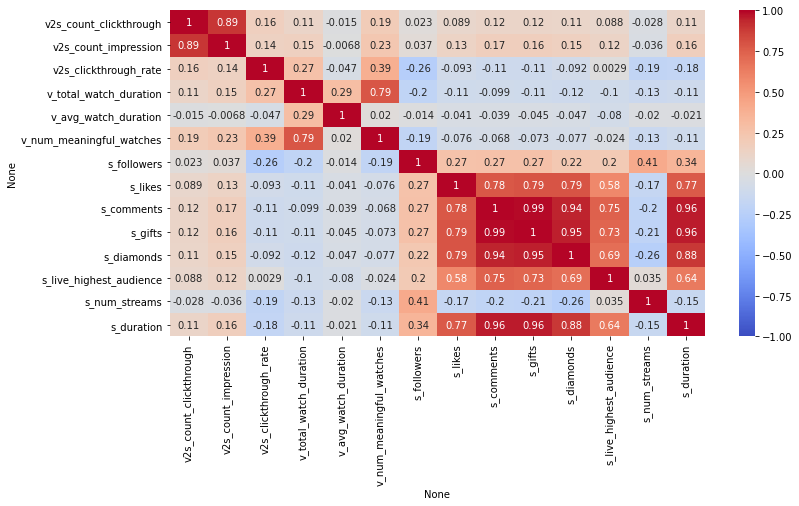

<AxesSubplot:xlabel='None', ylabel='None'>

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(s_corr_pdf, annot=True, vmin=-1, vmax=1, cmap='coolwarm')

In [ ]:
#to_drop = ['v2s_count_impression', 'v_num_meaningful_watches', 's_likes', 's_comments', 's_gifts', 's_diamonds', 's_live_highest_audience']
df_vs_v2s = df_vs_v2s.drop('v2s_count_clickthrough', 'v_total_watch_duration', 's_likes', 's_comments', 's_gifts', 's_diamonds', 's_live_highest_audience')
df_vs_v2s.display()

v_id s_id v2s_count_impression v2s_clickthrough_rate v_age v_gender v_avg_watch_duration v_num_meaningful_watches s_followers s_num_streams s_duration 11dKshB9Xm3M84b8 abLUvMmfx9wLL9P7 60 1.8333333333333333 35+ Female 105.10036385688296 376 1660 69 13750.840579710144 12VCucr8TFpXMfL2 Qe29qHDxbShTxiEY 12 1.4166666666666667 18 - 24 Male 264.7880758807588 812 1829 55 4952.854545454546 13PXM99UAPHV6VWw 4PDjvsUmc2v3dMRw 6 1.3333333333333333 35+ Unknown 417.6261467889908 222 97014 34 4400.205882352941 13WYsYcpMYG3hthv 4PDjvsUmc2v3dMRw 3 0.3333333333333333 Unknown Female 306.009009009009 40 97014 34 4400.205882352941 13dGt8XUce3fALWK 9xvReHoqw13qmGjg 1 0.0 25 - 35 Female 32.0 1 13376 53 8694.622641509433 13jLgPEjVarYjz7Q 71xTt59x42Lger32 1 0.0 13 - 17 Unknown 326.6666666666667 11 173629 24 3716.5833333333335 163o3GRghX9LiPuG YgV7VduExWq2bHWc 12 0.25 18 - 24 Female 20.862676056338028 9 318364 54 74887.20370370371 16Sms4i1jQVDU9eF e7qwc7wuBGFoiH82 1 0.0 18 - 24 Female 42.0 0 64346 64 6525.421875 18vcz1xhFHDa2LLg YgV7VduExWq2bHWc 1 0.0 18 - 24 Female 14.0 0 318364 54 74887.20370370371 19wBt3QAosqckWGa bAfubwu3yziPjoUf 15 0.0 35+ Female 38.72727272727273 2 759916 129 17944.682170542637 1A7b6mEYSTb3BnP9 YgV7VduExWq2bHWc 1 0.0 18 - 24 Female 32.74576271186441 3 318364 54 74887.20370370371 1AaqfW21EqciiP4V e2FbcNkCRBGKCTWL 3 0.3333333333333333 25 - 35 Female 809.046875 36 7662 34 4888.529411764706 1AjRtJuSVpNbtek9 hD1EMJgXDjN4UyYz 1 0.0 35+ Female 433.6 5 14378 29 4289.206896551724 1BAZbog4kTETxuKk Kno6G7eUvwG2nuJ8 2 1.5 35+ Female 148.04026845637583 49 10665 50 3098.98 1CCUe8xTDoFcsX8E YgV7VduExWq2bHWc 2731 4.679970706700842 18 - 24 Female 165.67328042328043 666 318364 54 74887.20370370371 1CR6gn3ZYKNujyf7 V9MKW9oCMJpUCQZD 7 0.0 35+ Female 141.11764705882354 20 587 67 2988.223880597015 1Cqq6jsfC3T7rGXP YgV7VduExWq2bHWc 59 0.5932203389830508 35+ Female 257.8910714285714 133 318364 54 74887.20370370371 1Crew32Y5i6MLXWy SFbtY5GcWSh5b4AS 1 0.0 18 - 24 Unknown 121.41379310344827 19 50976 96 17250.427083333332 1CxGUux55h1GtJZQ BsDomAiZ1BqVCCdP 1 0.0 25 - 35 Female 7.4375 0 386544 238 4095.747899159664 1D2GkjDXgKg3y7vv f64oRtHLjgB52VM8 1 0.0 18 - 24 Female 129.67194570135746 102 72810 140 6099.028571428571 1GN8KoQuVWrA6mg9 bNig8j8vEK8QR5MC 12 2.3333333333333335 Unknown Female 1755.469387755102 314 12991 28 7366.571428571428 1GaaK1DpuD6t4QXH 7u5gWJ2AjNg9oNpe 2 0.0 25 - 35 Female 31.5 0 399 106 3534.5377358490564 1GjqkixpQG9BCcqN 37RyQsnCECE6NPzH 2 1.0 18 - 24 Female 280.9686684073107 120 40337 34 3258.823529411765 1Hird2NfcYJJdeNf YgV7VduExWq2bHWc 2 0.0 35+ Male 21.5 0 318364 54 74887.20370370371 1K1gTUpve5LoyFeT 3fKbjGubmvGACRxG 3 0.6666666666666666 25 - 35 Female 1475.792618629174 416 279452 38 3347.8947368421054 1LynceaZXZehXZa1 ejXd1MUkqJZLLgq4 1 2.0 18 - 24 Female 1054.4396284829722 353 702 70 2957.442857142857 1MF56xtsjua8cEz5 of1CgeA1DGEszwKL 4 0.0 Unknown Female 465.21516164994426 308 3500 159 10937.314465408805 1NijD1DYAewFma4r YgV7VduExWq2bHWc 25 0.0 18 - 24 Unknown 141.8 1 318364 54 74887.20370370371 1P3Xuk3L8SpezYBB U6z68v7CVfV88T8E 1 0.0 13 - 17 Female 267.11290322580646 10 47839 77 7764.168831168831 1PFWmiXnLnJGitUP YgV7VduExWq2bHWc 3 0.0 Unknown Unknown 261.962962962963 3 318364 54 74887.20370370371 1PHnjvvzN48xd3vR NWGyoHqajREhiAdc 2 0.5 Unknown Unknown 146.19925685090573 492 71141 70 6826.428571428572 1SWZkSS6izF9sppm XknwZS7WNym1dcbR 3 0.0 18 - 24 Neutral 95.69 21 3408 24 6569.833333333333 1Tb7KQvsNzgpFdyS XFRq54eVLmqJmbqk 2 0.0 25 - 35 Female 141.55555555555554 4 11470 86 5981.3488372093025 1UNHwHqDMbfCrrhv uxRQik2sMRNQ5DGV 9 1.3333333333333333 Unknown Female 1060.0985828712262 1015 445 39 5632.410256410257 1VXBpvnbyqgqZK6b bAfubwu3yziPjoUf 16 0.0 25 - 35 Female 519.9120879120879 39 759916 129 17944.682170542637 1VdVYUaTdDF9mvFw YiYV5zKFJmNLnjSr 12 0.6666666666666666 25 - 35 Female 847.7 33 2998 21 11595.285714285714 1Wq8XuansJyjfUpf ZgZqLvgs9pR3WCvk 84 1.2380952380952381 18 - 24 Unknown 97.1889035667107 112 330 70 13811.3571428

**Outliers**

In [ ]:
# Detect Outliers

# df_vs_v2s_outliers = findOutliers(df_vs_v2s, df_num)

**Handle missing values**

In [ ]:
# encode gender, etc.
df_vs_v2s = df_vs_v2s.na.fill("Unknown", ["v_age"])
df_vs_v2s.select('v_age').distinct().show(truncate=False)

+--------+
v_age |
+--------+
Under 13|
Unknown |
25 - 35 |
13 - 17 |
18 - 24 |
35+ |
+--------+

In [ ]:
#from pyspark.ml.feature import StringIndexer
#indexer = StringIndexer(inputCols=['v_gender'], outputCols=['v_gender_proc'])
#df_vs_v2s = indexer.fit(vs_v2s).transform(vs_v2s)
#df_vs_v2s.show()

In [ ]:
# Gender: 0 = Female, 1 = Male, 2 = Unknown

#df_vs_v2s['v_gender', 'v_gender_proc'].display()

In [ ]:
df_vs_v2s = df_vs_v2s.withColumn("v2s_clickthrough_rate", when(df_vs_v2s.v2s_clickthrough_rate > 1, 1).otherwise(df_vs_v2s.v2s_clickthrough_rate))

In [ ]:
df_vs_v2s = df_vs_v2s.drop('v2s_count_clickthrough', 'v_total_watch_duration', 's_likes', 's_comments', 's_gifts', 's_diamonds', 's_live_highest_audience',
                          'follower_id', 'deg_2_followee', 'row_num', 's_replay_current_audience', 's_replay_highest_audience')
df_vs_v2s.display()

v_id s_id v2s_count_impression v2s_clickthrough_rate v_age v_gender v_avg_watch_duration v_num_meaningful_watches s_followers s_num_streams s_duration 11dKshB9Xm3M84b8 abLUvMmfx9wLL9P7 60 1.0 35+ Female 105.10036385688296 376 1660 69 13750.840579710144 12VCucr8TFpXMfL2 Qe29qHDxbShTxiEY 12 1.0 18 - 24 Male 264.7880758807588 812 1829 55 4952.854545454546 13PXM99UAPHV6VWw 4PDjvsUmc2v3dMRw 6 1.0 35+ Unknown 417.6261467889908 222 97014 34 4400.205882352941 13WYsYcpMYG3hthv 4PDjvsUmc2v3dMRw 3 0.3333333333333333 Unknown Female 306.009009009009 40 97014 34 4400.205882352941 13dGt8XUce3fALWK 9xvReHoqw13qmGjg 1 0.0 25 - 35 Female 32.0 1 13376 53 8694.622641509433 13jLgPEjVarYjz7Q 71xTt59x42Lger32 1 0.0 13 - 17 Unknown 326.6666666666667 11 173629 24 3716.5833333333335 163o3GRghX9LiPuG YgV7VduExWq2bHWc 12 0.25 18 - 24 Female 20.862676056338028 9 318364 54 74887.20370370371 16Sms4i1jQVDU9eF e7qwc7wuBGFoiH82 1 0.0 18 - 24 Female 42.0 0 64346 64 6525.421875 18vcz1xhFHDa2LLg YgV7VduExWq2bHWc 1 0.0 18 - 24 Female 14.0 0 318364 54 74887.20370370371 19wBt3QAosqckWGa bAfubwu3yziPjoUf 15 0.0 35+ Female 38.72727272727273 2 759916 129 17944.682170542637 1A7b6mEYSTb3BnP9 YgV7VduExWq2bHWc 1 0.0 18 - 24 Female 32.74576271186441 3 318364 54 74887.20370370371 1AaqfW21EqciiP4V e2FbcNkCRBGKCTWL 3 0.3333333333333333 25 - 35 Female 809.046875 36 7662 34 4888.529411764706 1AjRtJuSVpNbtek9 hD1EMJgXDjN4UyYz 1 0.0 35+ Female 433.6 5 14378 29 4289.206896551724 1BAZbog4kTETxuKk Kno6G7eUvwG2nuJ8 2 1.0 35+ Female 148.04026845637583 49 10665 50 3098.98 1CCUe8xTDoFcsX8E YgV7VduExWq2bHWc 2731 1.0 18 - 24 Female 165.67328042328043 666 318364 54 74887.20370370371 1CR6gn3ZYKNujyf7 V9MKW9oCMJpUCQZD 7 0.0 35+ Female 141.11764705882354 20 587 67 2988.223880597015 1Cqq6jsfC3T7rGXP YgV7VduExWq2bHWc 59 0.5932203389830508 35+ Female 257.8910714285714 133 318364 54 74887.20370370371 1Crew32Y5i6MLXWy SFbtY5GcWSh5b4AS 1 0.0 18 - 24 Unknown 121.41379310344827 19 50976 96 17250.427083333332 1CxGUux55h1GtJZQ BsDomAiZ1BqVCCdP 1 0.0 25 - 35 Female 7.4375 0 386544 238 4095.747899159664 1D2GkjDXgKg3y7vv f64oRtHLjgB52VM8 1 0.0 18 - 24 Female 129.67194570135746 102 72810 140 6099.028571428571 1GN8KoQuVWrA6mg9 bNig8j8vEK8QR5MC 12 1.0 Unknown Female 1755.469387755102 314 12991 28 7366.571428571428 1GaaK1DpuD6t4QXH 7u5gWJ2AjNg9oNpe 2 0.0 25 - 35 Female 31.5 0 399 106 3534.5377358490564 1GjqkixpQG9BCcqN 37RyQsnCECE6NPzH 2 1.0 18 - 24 Female 280.9686684073107 120 40337 34 3258.823529411765 1Hird2NfcYJJdeNf YgV7VduExWq2bHWc 2 0.0 35+ Male 21.5 0 318364 54 74887.20370370371 1K1gTUpve5LoyFeT 3fKbjGubmvGACRxG 3 0.6666666666666666 25 - 35 Female 1475.792618629174 416 279452 38 3347.8947368421054 1LynceaZXZehXZa1 ejXd1MUkqJZLLgq4 1 1.0 18 - 24 Female 1054.4396284829722 353 702 70 2957.442857142857 1MF56xtsjua8cEz5 of1CgeA1DGEszwKL 4 0.0 Unknown Female 465.21516164994426 308 3500 159 10937.314465408805 1NijD1DYAewFma4r YgV7VduExWq2bHWc 25 0.0 18 - 24 Unknown 141.8 1 318364 54 74887.20370370371 1P3Xuk3L8SpezYBB U6z68v7CVfV88T8E 1 0.0 13 - 17 Female 267.11290322580646 10 47839 77 7764.168831168831 1PFWmiXnLnJGitUP YgV7VduExWq2bHWc 3 0.0 Unknown Unknown 261.962962962963 3 318364 54 74887.20370370371 1PHnjvvzN48xd3vR NWGyoHqajREhiAdc 2 0.5 Unknown Unknown 146.19925685090573 492 71141 70 6826.428571428572 1SWZkSS6izF9sppm XknwZS7WNym1dcbR 3 0.0 18 - 24 Neutral 95.69 21 3408 24 6569.833333333333 1Tb7KQvsNzgpFdyS XFRq54eVLmqJmbqk 2 0.0 25 - 35 Female 141.55555555555554 4 11470 86 5981.3488372093025 1UNHwHqDMbfCrrhv uxRQik2sMRNQ5DGV 9 1.0 Unknown Female 1060.0985828712262 1015 445 39 5632.410256410257 1VXBpvnbyqgqZK6b bAfubwu3yziPjoUf 16 0.0 25 - 35 Female 519.9120879120879 39 759916 129 17944.682170542637 1VdVYUaTdDF9mvFw YiYV5zKFJmNLnjSr 12 0.6666666666666666 25 - 35 Female 847.7 33 2998 21 11595.285714285714 1Wq8XuansJyjfUpf ZgZqLvgs9pR3WCvk 84 1.0 18 - 24 Unknown 97.1889035667107 112 330 70 13811.357142857143 1ZEcqFk1m1B2Apj3 mRovf8kao5wRqkVo 2 0.0 18 - 24 Female 187.6535433070866 135 5784 40 8370.325 1biE

# Block 1

Out[38]:

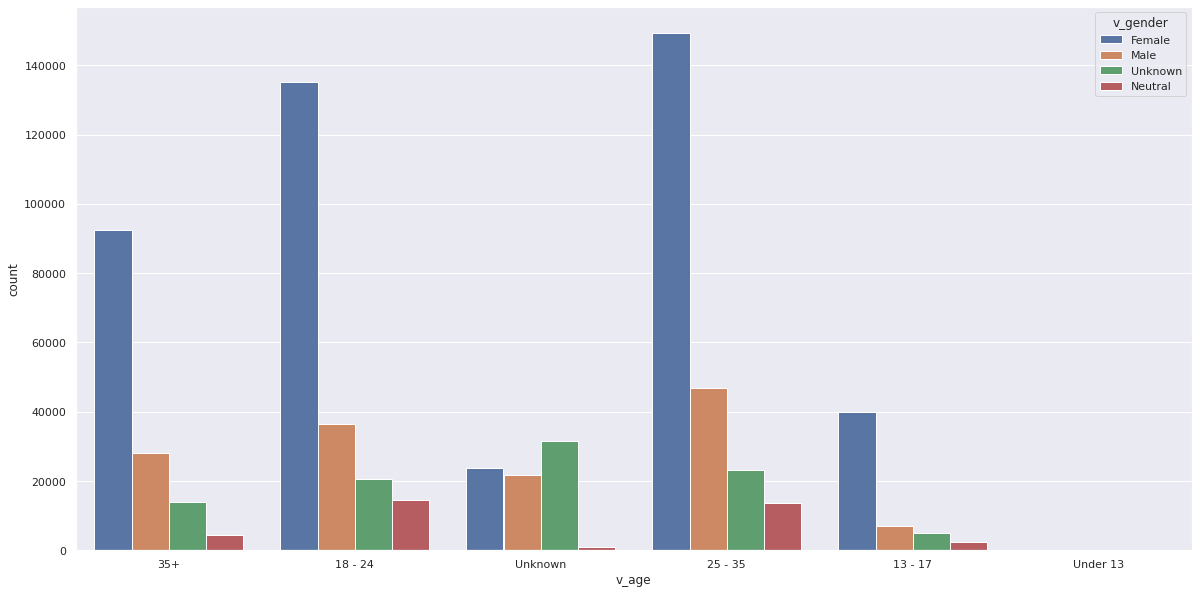

<AxesSubplot:xlabel='v_age', ylabel='count'>

In [ ]:
# Number of people in each age group by gender

sns.set_theme()
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x='v_age', hue='v_gender', data=df_vs_v2s.toPandas())

In [ ]:
#df_vs_v2s.agg({'v2s_count_impression': 'avg'}).collect()

Out[40]:

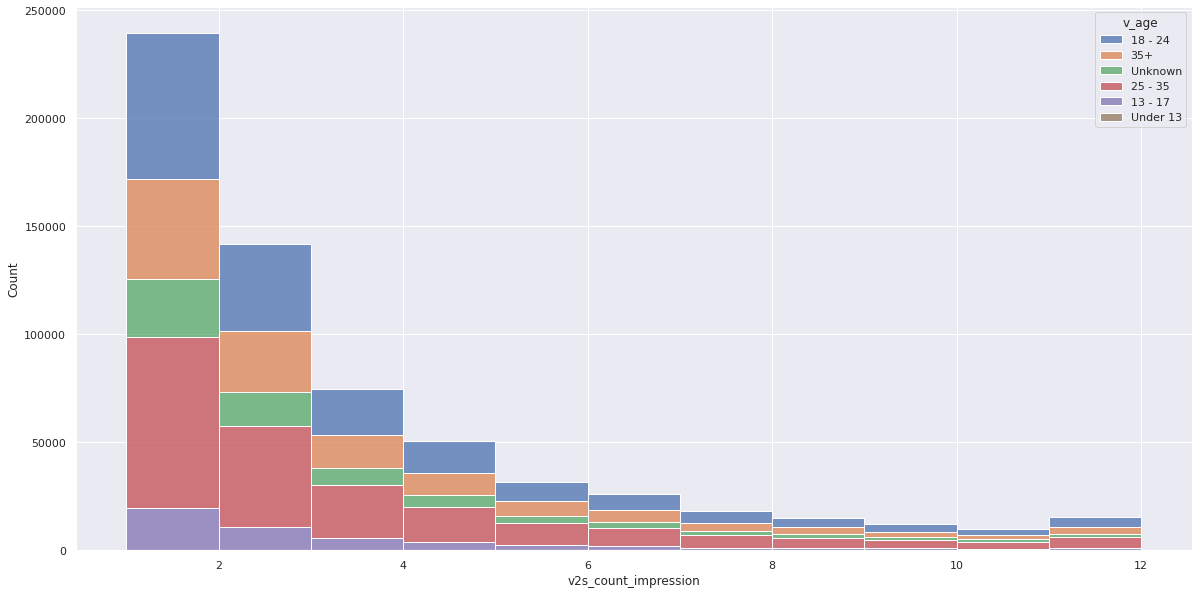

<AxesSubplot:xlabel='v2s_count_impression', ylabel='Count'>

In [ ]:
# Distribution of impressions by age group (histogram & kernel density),

sns.set_theme()
sns.set(rc={'figure.figsize':(20,10)})
#sns.countplot(x='v2s_count_impression', hue='v_age', data=df_vs_v2s.toPandas())
tmp = df_vs_v2s[df_vs_v2s['v2s_count_impression'] < 13] # avg impression = 13
sns.histplot(tmp.toPandas(), x='v2s_count_impression', hue='v_age', stat='count', binwidth=1, multiple='stack')

Most users have been shown 12 impressions

In [ ]:
tmp.count()

Out[41]: 635434

Out[42]:

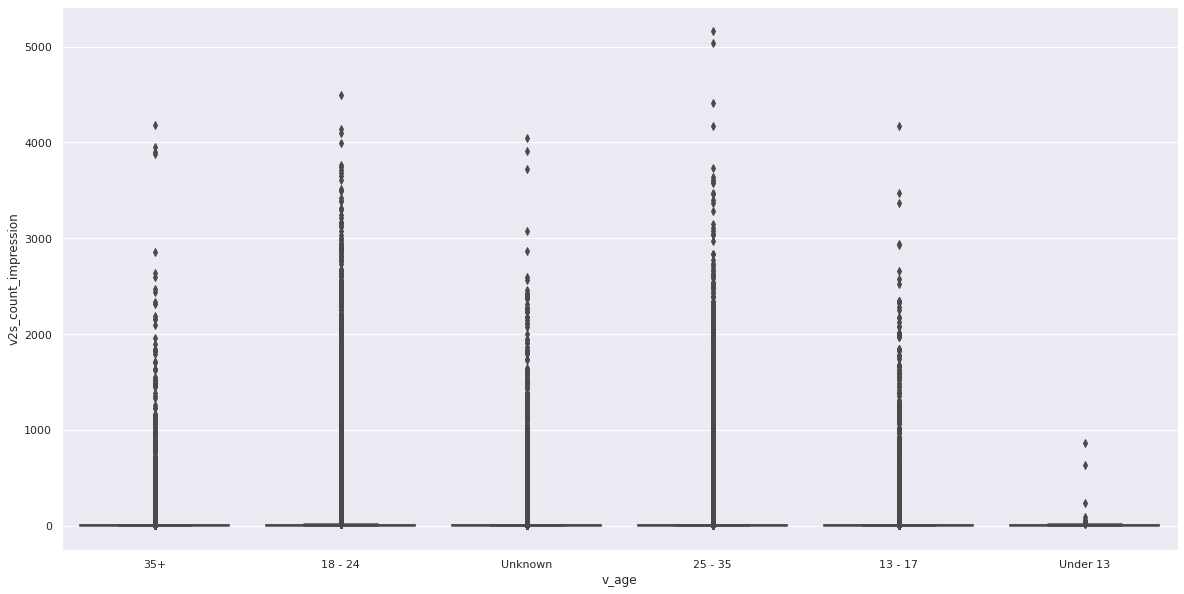

<AxesSubplot:xlabel='v_age', ylabel='v2s_count_impression'>

In [ ]:
# Check outliers of impressions by age group

sns.boxplot(data=df_vs_v2s.toPandas(), y='v2s_count_impression', x='v_age')

The distribution of impressions for ages 35+, 25-35, and Unknown are similar; while, ages 18-24 and 13-17 are similar.

Out[43]:

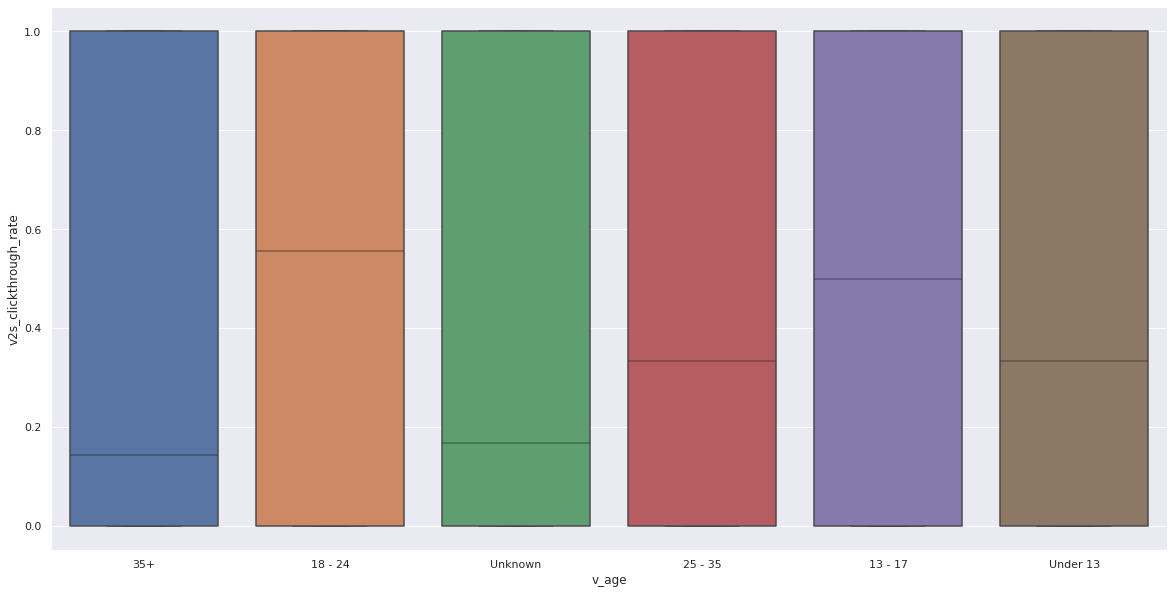

<AxesSubplot:xlabel='v_age', ylabel='v2s_clickthrough_rate'>

In [ ]:
# Click-through rate distribution by age groups

sns.boxenplot(data=df_vs_v2s.toPandas(), x='v_age', y='v2s_clickthrough_rate')

18-24 age group has the highest CTR of roughly 0.6, followed by 13-17 CTR of 0.5. Age groups 25-35 and under 13 have the same CTR of roughly 0.4. Age groups 35+ and Unknown have roughly the same CTR of roughly 0.2

In [ ]:
# Group all users by their click behaviors,
# normalize,

bins = [-1, 0, 0.1, 0.2, 0.4, 1]
labels = ['0', '<10%', '10%-20%', '20%-40%', '>40%']
tmp = df_vs_v2s.toPandas()
tmp['v2s_clickthrough_rate'] = pd.cut(tmp.v2s_clickthrough_rate, bins, labels = labels,include_lowest = True)
tmp.v2s_clickthrough_rate.value_counts(normalize=True, sort=True)

Out[44]: >40% 0.499521
0 0.455216
20%-40% 0.031413
10%-20% 0.011009
<10% 0.002840
Name: v2s_clickthrough_rate, dtype: float64

50.0% of viewers has greater than 40% CTR, 45.5% of viewers has never clicked on any stream, 3.1% of viewers has a 20%-40% CTR, and 1.1% of viewers has a 10%–20% CTR

In [ ]:
# The proportion of people who clicked by age group

tmp = df_vs_v2s.toPandas()
tmp_clicked = tmp[tmp['v2s_clickthrough_rate'] > 0]
tmp_clicked.v_age.value_counts(normalize=True)

Out[45]: 25 - 35 0.322951
18 - 24 0.313508
35+ 0.182203
Unknown 0.102501
13 - 17 0.078657
Under 13 0.000181
Name: v_age, dtype: float64

Among all viewers who clicked on streams, 33.3% is from age group 25-35

Out[46]:

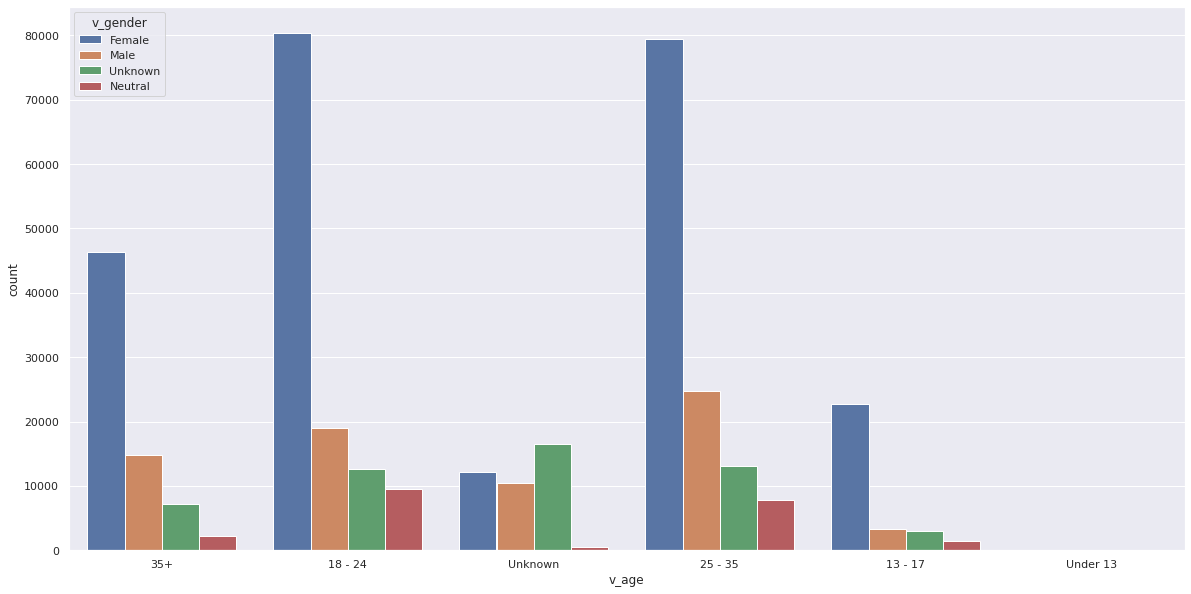

<AxesSubplot:xlabel='v_age', ylabel='count'>

In [ ]:
# Number of people in each age group among clicked users by gender

sns.countplot(x='v_age', hue='v_gender', data=tmp_clicked)

Female viewers in age group 18-24 consists of large proportion among viewers who clicked streams

<command-4379540477478907>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 tmp_clicked['v2s_clickthrough_rate'] = pd.cut(tmp.v2s_clickthrough_rate, bins, labels = labels,include_lowest = True)
Out[47]:

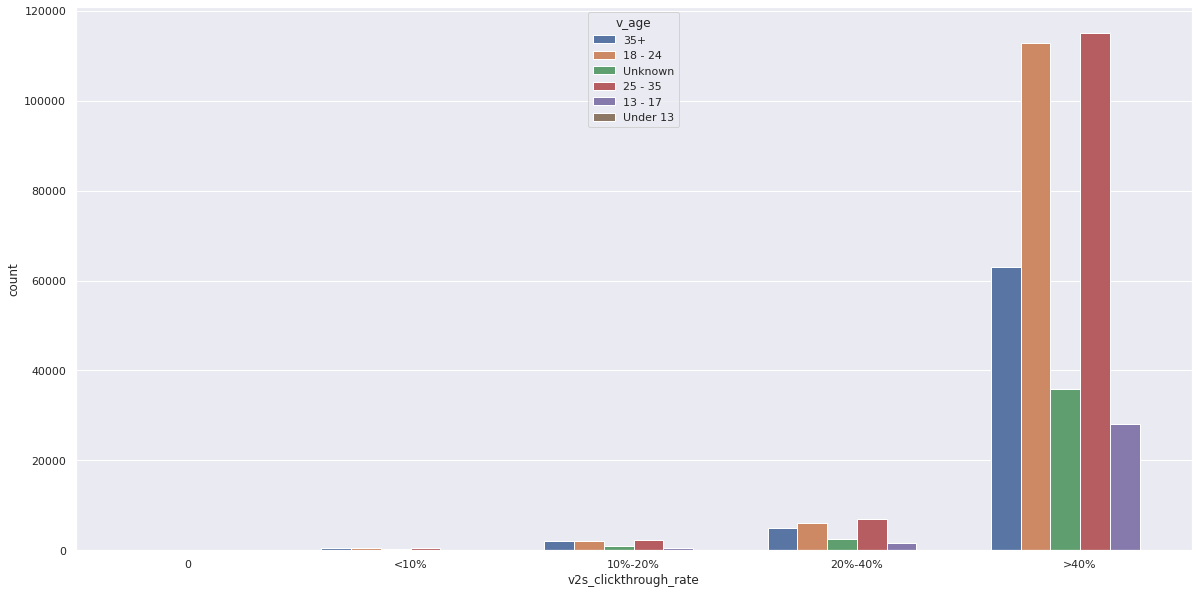

<AxesSubplot:xlabel='v2s_clickthrough_rate', ylabel='count'>

In [ ]:
# Distribution of age_group in CTR groups (countplot),
# then create a subset for such people (histplot)
bins = [-1, 0, 0.1, 0.2, 0.4, 1]
labels = ['0', '<10%', '10%-20%', '20%-40%', '>40%']
tmp = df_vs_v2s.toPandas()
tmp_clicked = tmp[tmp['v2s_clickthrough_rate'] > 0]
tmp_clicked['v2s_clickthrough_rate'] = pd.cut(tmp.v2s_clickthrough_rate, bins, labels = labels,include_lowest = True)
tmp_clicked

sns.countplot(x='v2s_clickthrough_rate', hue='v_age', data=tmp_clicked)

Among all users who click on the streams, viewers from age group 25-35 tend to have the highest click-through rate. The largest amount of click-through rate falls into the >40% group.

<command-1504991950514885>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 tmp_clicked_impressions['v2s_clickthrough_rate'] = pd.cut(tmp.v2s_clickthrough_rate, bins, labels = labels,include_lowest = True)
Out[48]:

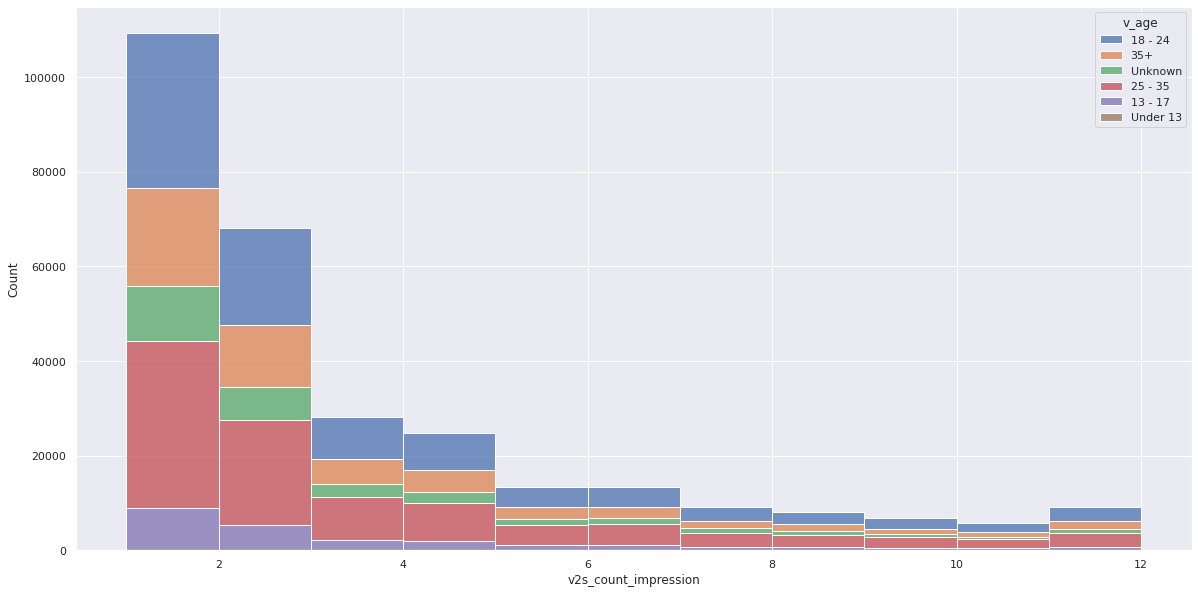

<AxesSubplot:xlabel='v2s_count_impression', ylabel='Count'>

In [ ]:
bins = [-1, 0, 0.1, 0.2, 0.4, 1]
labels = ['0', '<10%', '10%-20%', '20%-40%', '>40%']
tmp = df_vs_v2s.toPandas()
tmp_clicked = tmp[tmp['v2s_clickthrough_rate'] > 0]
tmp_clicked_impressions = tmp_clicked[tmp_clicked['v2s_count_impression'] < 13]
tmp_clicked_impressions['v2s_clickthrough_rate'] = pd.cut(tmp.v2s_clickthrough_rate, bins, labels = labels,include_lowest = True)

tmp_clicked40 = tmp_clicked_impressions[tmp_clicked_impressions['v2s_clickthrough_rate'] == '>40%']

# Plot the distribution of impressions by age group 
sns.histplot(tmp_clicked40, x='v2s_count_impression', hue='v_age', binwidth=1, stat='count', multiple='stack')

Most people have more than 1 time impression; hence, more appearances of streams are crucial to get a better CTR.

In [ ]:
bins = [-1, 0, 0.1, 0.2, 0.4, 1]
labels = ['0', '<10%', '10%-20%', '20%-40%', '>40%']
tmp = df_vs_v2s.toPandas()
tmp_clicked = tmp[tmp['v2s_clickthrough_rate'] > 0]
tmp_clicked_meaningful_watch = tmp_clicked[tmp_clicked['v_duration'] > 90]
tmp_clicked_meaningful_watch['v2s_clickthrough_rate'] = pd.cut(tmp.v2s_clickthrough_rate, bins, labels = labels,include_lowest = True)

tmp_clicked40 = tmp_clicked_meaningful_watch[tmp_clicked_meaningful_watch['v2s_clickthrough_rate'] == '>40%']

# Plot the distribution of impressions by age group 
sns.histplot(tmp_clicked40, x='v2s_count_impression', hue='v_age', binwidth=1, stat='count', multiple='stack')

In [ ]:
# Number of meaningful watches with >40% CTR

bins = [-1, 0, 0.1, 0.2, 0.4, 1]
labels = ['0', '<10%', '10%-20%', '20%-40%', '>40%']
tmp = df_vs_v2s.toPandas()
tmp_clicked = tmp[tmp['v2s_clickthrough_rate'] > 0]
tmp_clicked_meaningful_watch = tmp_clicked[tmp_clicked['v_avg_watch_duration'] > 90]
tmp_clicked_meaningful_watch['v2s_clickthrough_rate'] = pd.cut(tmp.v2s_clickthrough_rate, bins, labels = labels,include_lowest = True)

tmp_clicked40 = tmp_clicked_meaningful_watch[tmp_clicked_meaningful_watch['v2s_clickthrough_rate'] == '>40%']['v_id'].count()
print('Number of meaningful watches with >40% CTR: ', tmp_clicked40)

<command-1504991950517549>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 tmp_clicked_meaningful_watch['v2s_clickthrough_rate'] = pd.cut(tmp.v2s_clickthrough_rate, bins, labels = labels,include_lowest = True)
Number of meaningful watches with >40% CTR: 276627

In [ ]:
# Number of non-meaningful watches

bins = [-1, 0, 0.1, 0.2, 0.4, 1]
labels = ['0', '<10%', '10%-20%', '20%-40%', '>40%']
tmp = df_vs_v2s.toPandas()
tmp_clicked = tmp[tmp['v2s_clickthrough_rate'] > 0]
tmp_clicked_meaningful_watch = tmp_clicked[tmp_clicked['v_avg_watch_duration'] < 90]
tmp_clicked_meaningful_watch['v2s_clickthrough_rate'] = pd.cut(tmp.v2s_clickthrough_rate, bins, labels = labels,include_lowest = True)

tmp_clicked40 = tmp_clicked_meaningful_watch[tmp_clicked_meaningful_watch['v2s_clickthrough_rate'] == '>40%']['v_id'].count()
print('Number of non-meaningful watches with >40% CTR: ', tmp_clicked40)

<command-1504991950517563>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 tmp_clicked_meaningful_watch['v2s_clickthrough_rate'] = pd.cut(tmp.v2s_clickthrough_rate, bins, labels = labels,include_lowest = True)
Number of non-meaningful watches with >40% CTR: 78637

In [ ]:
perc_meaningful_watch = 276627/(276627+78637)
print(perc_meaningful_watch)

0.7786519320843092

**Insights**
- 45.5% of viewers do not click on streams at all.
- Viewers from age groups 18-24 and 25-35 are the target audience. Combined, they consist of 64.7% of all clicked viewers. However, the streams are not shown dissimilarly to different age groups. It would be better to show more streams that fit females' interest.
- There is a 50.0% of viewers with a click-through rate greater than 40%; hence, half of the audience would likely to click the streams. 64.7% of them are from ages 25-35 and 18-24, and most are females.
  - Also, 77.9% of viewers achieved meaningful watches from the 50.0% of viewers with a CTR greater than 40% , which watch duration is greater than 90 seconds.

# Block 2

In [ ]:
# Generic
import pandas as pd
import numpy as np

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
df_vs_v2s.display()

v_id s_id v2s_count_impression v2s_clickthrough_rate v_age v_gender v_avg_watch_duration v_num_meaningful_watches s_followers s_num_streams s_duration 11dKshB9Xm3M84b8 abLUvMmfx9wLL9P7 60 1.8333333333333333 35+ Female 105.10036385688296 376 1660 69 13750.840579710144 12VCucr8TFpXMfL2 Qe29qHDxbShTxiEY 12 1.4166666666666667 18 - 24 Male 264.7880758807588 812 1829 55 4952.854545454546 13PXM99UAPHV6VWw 4PDjvsUmc2v3dMRw 6 1.3333333333333333 35+ Unknown 417.6261467889908 222 97014 34 4400.205882352941 13WYsYcpMYG3hthv 4PDjvsUmc2v3dMRw 3 0.3333333333333333 Unknown Female 306.009009009009 40 97014 34 4400.205882352941 13dGt8XUce3fALWK 9xvReHoqw13qmGjg 1 0.0 25 - 35 Female 32.0 1 13376 53 8694.622641509433 13jLgPEjVarYjz7Q 71xTt59x42Lger32 1 0.0 13 - 17 Unknown 326.6666666666667 11 173629 24 3716.5833333333335 163o3GRghX9LiPuG YgV7VduExWq2bHWc 12 0.25 18 - 24 Female 20.862676056338028 9 318364 54 74887.20370370371 16Sms4i1jQVDU9eF e7qwc7wuBGFoiH82 1 0.0 18 - 24 Female 42.0 0 64346 64 6525.421875 18vcz1xhFHDa2LLg YgV7VduExWq2bHWc 1 0.0 18 - 24 Female 14.0 0 318364 54 74887.20370370371 19wBt3QAosqckWGa bAfubwu3yziPjoUf 15 0.0 35+ Female 38.72727272727273 2 759916 129 17944.682170542637 1A7b6mEYSTb3BnP9 YgV7VduExWq2bHWc 1 0.0 18 - 24 Female 32.74576271186441 3 318364 54 74887.20370370371 1AaqfW21EqciiP4V e2FbcNkCRBGKCTWL 3 0.3333333333333333 25 - 35 Female 809.046875 36 7662 34 4888.529411764706 1AjRtJuSVpNbtek9 hD1EMJgXDjN4UyYz 1 0.0 35+ Female 433.6 5 14378 29 4289.206896551724 1BAZbog4kTETxuKk Kno6G7eUvwG2nuJ8 2 1.5 35+ Female 148.04026845637583 49 10665 50 3098.98 1CCUe8xTDoFcsX8E YgV7VduExWq2bHWc 2731 4.679970706700842 18 - 24 Female 165.67328042328043 666 318364 54 74887.20370370371 1CR6gn3ZYKNujyf7 V9MKW9oCMJpUCQZD 7 0.0 35+ Female 141.11764705882354 20 587 67 2988.223880597015 1Cqq6jsfC3T7rGXP YgV7VduExWq2bHWc 59 0.5932203389830508 35+ Female 257.8910714285714 133 318364 54 74887.20370370371 1Crew32Y5i6MLXWy SFbtY5GcWSh5b4AS 1 0.0 18 - 24 Unknown 121.41379310344827 19 50976 96 17250.427083333332 1CxGUux55h1GtJZQ BsDomAiZ1BqVCCdP 1 0.0 25 - 35 Female 7.4375 0 386544 238 4095.747899159664 1D2GkjDXgKg3y7vv f64oRtHLjgB52VM8 1 0.0 18 - 24 Female 129.67194570135746 102 72810 140 6099.028571428571 1GN8KoQuVWrA6mg9 bNig8j8vEK8QR5MC 12 2.3333333333333335 Unknown Female 1755.469387755102 314 12991 28 7366.571428571428 1GaaK1DpuD6t4QXH 7u5gWJ2AjNg9oNpe 2 0.0 25 - 35 Female 31.5 0 399 106 3534.5377358490564 1GjqkixpQG9BCcqN 37RyQsnCECE6NPzH 2 1.0 18 - 24 Female 280.9686684073107 120 40337 34 3258.823529411765 1Hird2NfcYJJdeNf YgV7VduExWq2bHWc 2 0.0 35+ Male 21.5 0 318364 54 74887.20370370371 1K1gTUpve5LoyFeT 3fKbjGubmvGACRxG 3 0.6666666666666666 25 - 35 Female 1475.792618629174 416 279452 38 3347.8947368421054 1LynceaZXZehXZa1 ejXd1MUkqJZLLgq4 1 2.0 18 - 24 Female 1054.4396284829722 353 702 70 2957.442857142857 1MF56xtsjua8cEz5 of1CgeA1DGEszwKL 4 0.0 Unknown Female 465.21516164994426 308 3500 159 10937.314465408805 1NijD1DYAewFma4r YgV7VduExWq2bHWc 25 0.0 18 - 24 Unknown 141.8 1 318364 54 74887.20370370371 1P3Xuk3L8SpezYBB U6z68v7CVfV88T8E 1 0.0 13 - 17 Female 267.11290322580646 10 47839 77 7764.168831168831 1PFWmiXnLnJGitUP YgV7VduExWq2bHWc 3 0.0 Unknown Unknown 261.962962962963 3 318364 54 74887.20370370371 1PHnjvvzN48xd3vR NWGyoHqajREhiAdc 2 0.5 Unknown Unknown 146.19925685090573 492 71141 70 6826.428571428572 1SWZkSS6izF9sppm XknwZS7WNym1dcbR 3 0.0 18 - 24 Neutral 95.69 21 3408 24 6569.833333333333 1Tb7KQvsNzgpFdyS XFRq54eVLmqJmbqk 2 0.0 25 - 35 Female 141.55555555555554 4 11470 86 5981.3488372093025 1UNHwHqDMbfCrrhv uxRQik2sMRNQ5DGV 9 1.3333333333333333 Unknown Female 1060.0985828712262 1015 445 39 5632.410256410257 1VXBpvnbyqgqZK6b bAfubwu3yziPjoUf 16 0.0 25 - 35 Female 519.9120879120879 39 759916 129 17944.682170542637 1VdVYUaTdDF9mvFw YiYV5zKFJmNLnjSr 12 0.6666666666666666 25 - 35 Female 847.7 33 2998 21 11595.285714285714 1Wq8XuansJyjfUpf ZgZqLvgs9pR3WCvk 84 1.2380952380952381 18 - 24 Unknown 97.1889035667107 112 330 70 13811.3571428

In [ ]:
tmp = df_vs_v2s.toPandas()

In [ ]:
tmp = tmp.drop(['v_id', 's_id'], axis=1)

In [ ]:
#from pyspark.ml.feature import StringIndexer
#indexer = StringIndexer(inputCols=['v_age', 'v_gender'], outputCols=['v_age_proc', 'v_gender_proc'])
#indexer_fitted = indexer.fit(df_vs_v2s)
#df_indexed = indexer_fitted.transform(df_vs_v2s)
#df_indexed.show()

onehot = pd.get_dummies(data=tmp, columns=['v_age', 'v_gender'])
onehot

Out[58]:

v2s_count_impression 
 v2s_clickthrough_rate 
 v_avg_watch_duration 
 v_num_meaningful_watches 
 s_followers 
 s_num_streams 
 s_duration 
 v_age_13 - 17 
 v_age_18 - 24 
 v_age_25 - 35 
 v_age_35+ 
 v_age_Under 13 
 v_age_Unknown 
 v_gender_Female 
 v_gender_Male 
 v_gender_Neutral 
 v_gender_Unknown 
 
 
 
 
 0 
 60 
 1.833333 
 105.100364 
 376 
 1660 
 69 
 13750.840580 
 0 
 0 
 0 
 1 
 0 
 0 
 1 
 0 
 0 
 0 
 
 
 1 
 12 
 1.416667 
 264.788076 
 812 
 1829 
 55 
 4952.854545 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 
 
 2 
 6 
 1.333333 
 417.626147 
 222 
 97014 
 34 
 4400.205882 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 3 
 3 
 0.333333 
 306.009009 
 40 
 97014 
 34 
 4400.205882 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 0 
 0 
 0 
 
 
 4 
 1 
 0.000000 
 32.000000 
 1 
 13376 
 53 
 8694.622642 
 0 
 0 
 1 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 711250 
 2 
 1.000000 
 398.093713 
 351 
 132060 
 71 
 3693.915493 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 711251 
 4 
 0.250000 
 1847.125000 
 8 
 759916 
 129 
 17944.682171 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 1 
 0 
 0 
 
 
 711252 
 2 
 1.500000 
 108.137931 
 7 
 71141 
 70 
 6826.428571 
 1 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 
 
 711253 
 6 
 0.000000 
 326.021739 
 16 
 318364 
 54 
 74887.203704 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 711254 
 11 
 0.000000 
 142.280000 
 26 
 318364 
 54 
 74887.203704 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 1 
 0 
 0 
 
 
 
 711255 rows × 17 columns

In [ ]:
# Splitting the X and Y into the
# Training set and Testing set
from sklearn.model_selection import train_test_split
  
train, test = train_test_split(onehot, test_size = 0.2, random_state = 0)

In [ ]:
# performing preprocessing part
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
X_train = sc.fit_transform(train)
X_test = sc.transform(test)

In [ ]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA
  
pca = PCA(n_components = 5)
  
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
  
explained_variance = pca.explained_variance_ratio_
explained_variance

Out[61]: array([0.11375949, 0.11124012, 0.08694702, 0.08047773, 0.07866369])

In [ ]:
pca.explained_variance_ratio_.cumsum()

Out[62]: array([0.11375949, 0.22499961, 0.31194663, 0.39242437, 0.47108806])

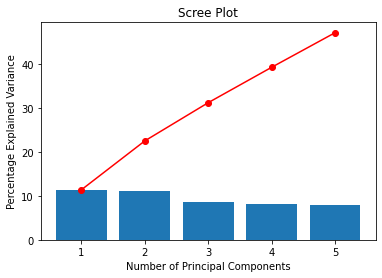

In [ ]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Percentage Explained Variance")
    plt.title("Scree Plot")
    plt.show(block=False)

display_scree_plot(pca)

In [ ]:
#https://medium.com/analytics-vidhya/discovering-customer-segments-using-machine-learning-part-2-dimension-reduction-and-clustering-36c6108599f9
#https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/2a.%20PCA.ipynb
#https://www.statology.org/scree-plot-python/